<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Подготовка-к-машинному-обучению" data-toc-modified-id="Подготовка-к-машинному-обучению-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка к машинному обучению</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Проверка-на-тестовой-выборке-и-сравнение-с-константной-моделью" data-toc-modified-id="Проверка-на-тестовой-выборке-и-сравнение-с-константной-моделью-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Проверка на тестовой выборке и сравнение с константной моделью</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Изучение данных

In [ ]:
#импортируем необходимые для работы библиотеки
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time
import catboost
import lightgbm
from sklearn.dummy import DummyClassifier

In [ ]:
#считаем датасет и сохраним его в переменной

pth1 = '/content/toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Ошибка')

In [ ]:
data.head() #выведем первые 5 строк получившегося датафрейма

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
data.info() #теперь выведем основную информацию о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


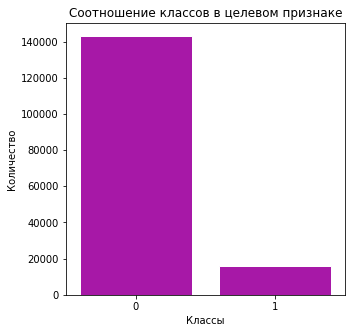

In [ ]:
#посмотрим на соотношение классов в целевом признаке
f, ax = plt.subplots(figsize=(5, 5))
sns.set_style('whitegrid')
sns.countplot(x=data['toxic'], color='m').set(title='Соотношение классов в целевом признаке')
ax.set(ylabel="Количество", xlabel="Классы")
plt.show();

Как мы видим, большинство комментариев - позитивные.

### Подготовка к машинному обучению

In [ ]:
#лемматизируем тексты
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nltk.download('punkt')
nltk.download('wordnet')

def lemmatize(text):
    doc = nlp(text)
    lemmatized_output = " ".join([token.lemma_ for token in doc])
    return lemmatized_output

#проверим, что лемматизация проходит успешно, на тестовых предложениях
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
print(df_my)


print(df_my['text'].apply(lemmatize))

                                                text
0  The striped bats are hanging on their feet for...
1      you should be ashamed of yourself went worked
0    the stripe bat be hang on their foot for good
1        you should be ashamed of yourself go work
Name: text, dtype: object


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#лемматизация тестовых предложений прошла успешно, применим нашу функцию ко всему датафрейму

tqdm.pandas()
data['lemm_text'] = data['text'].progress_apply(lemmatize)

data.head()

100%|██████████| 159292/159292 [18:29<00:00, 143.54it/s]


,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,Explanation \n why the edit make under my user...
1,1,D'aww! He matches this background colour I'm s...,0,D'aww ! he match this background colour I be s...
2,2,"Hey man, I'm really not trying to edit war. It...",0,"hey man , I be really not try to edit war . it..."
3,3,"""\nMore\nI can't make any real suggestions on ...",0,""" \n More \n I can not make any real suggestio..."
4,4,"You, sir, are my hero. Any chance you remember...",0,"you , sir , be my hero . any chance you rememb..."


In [ ]:
#очистим тексты от лиших символов с помощью регулярных выражений

def clear_text(text):
    clear_text = re.sub(r'[^a-zA-z ]', ' ', text)
    clear_text = " ".join(clear_text.split())

    return clear_text

data['clean_text'] = data['lemm_text'].apply(clear_text)

data.head()

,Unnamed: 0,text,toxic,lemm_text,clean_text
0,0,Explanation\nWhy the edits made under my usern...,0,Explanation \n why the edit make under my user...,Explanation why the edit make under my usernam...
1,1,D'aww! He matches this background colour I'm s...,0,D'aww ! he match this background colour I be s...,D aww he match this background colour I be see...
2,2,"Hey man, I'm really not trying to edit war. It...",0,"hey man , I be really not try to edit war . it...",hey man I be really not try to edit war it be ...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,""" \n More \n I can not make any real suggestio...",More I can not make any real suggestion on imp...
4,4,"You, sir, are my hero. Any chance you remember...",0,"you , sir , be my hero . any chance you rememb...",you sir be my hero any chance you remember wha...


In [ ]:
#далее разделим датафрейм на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(data['clean_text'], data['toxic'],
                                                                            test_size=0.25,
                                                                            random_state=12345)

**Вывод:** мы считали исходный датасет и изучили его, а также подготовили данные для дальнейшего обучения: лемматизировали, очистили тексты от лишних символов, разделили датафрейм на обучающую и тестовую выборки.

## Обучение

Обучим три модели: логистическую регрессию, CatBoost и LightGBM. Выбирать лучшие значения гиперпараметров будем с помощью GridSearchCV. По условиям исследования для оценки качества моделей необходимо использовать метрику F1, и её значение должно быть не меньше 0.75.

In [ ]:
#инициализируем пайплайн для обучения моделей: он будет векторизовать тексты, обучать модели
#а также с помощью GridSearchCV подбирать гиперпараметры
nltk.download('stopwords')
stop_list = list(stopwords.words('english'))

def training(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stop_list, decode_error='ignore')),
        ('model', model)])
    grid = GridSearchCV(pipeline, cv = 3, n_jobs = -1, param_grid = params ,scoring = 'f1', verbose = 1)
    grid.fit(features_train, target_train)
    print('Лучший результат F1:', grid.best_score_)
    print('Лучшие гиперпараметры:', grid.best_params_)
    return grid

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Логистическая регрессия

In [ ]:
model_lr = training(LogisticRegression(solver='saga'), {"model__C": np.arange(5, 15), "model__penalty": ['l1', 'l2']})

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

Лучший результат F1: 0.7733771909698653
Лучшие гиперпараметры: {'model__C': 6, 'model__penalty': 'l1'}


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


### CatBoost

In [ ]:
model_cb = training(catboost.CatBoostClassifier(),
                    {"model__learning_rate": [0.01, 0.05], "model__depth": [4, 6], "model__iterations": [10, 50]})

Fitting 3 folds for each of 8 candidates, totalling 24 fits
0:	learn: 0.6823259	total: 968ms	remaining: 8.71s
1:	learn: 0.6722235	total: 1.89s	remaining: 7.58s
2:	learn: 0.6623275	total: 2.79s	remaining: 6.51s
3:	learn: 0.6523453	total: 3.67s	remaining: 5.51s
4:	learn: 0.6428623	total: 4.64s	remaining: 4.64s
5:	learn: 0.6333432	total: 5.59s	remaining: 3.73s
6:	learn: 0.6243545	total: 6.54s	remaining: 2.8s
7:	learn: 0.6156901	total: 7.42s	remaining: 1.86s
8:	learn: 0.6067841	total: 8.35s	remaining: 928ms
9:	learn: 0.5982984	total: 9.27s	remaining: 0us
0:	learn: 0.6825103	total: 962ms	remaining: 8.66s
1:	learn: 0.6721447	total: 1.97s	remaining: 7.88s
2:	learn: 0.6617636	total: 2.96s	remaining: 6.9s
3:	learn: 0.6523942	total: 3.95s	remaining: 5.92s
4:	learn: 0.6434222	total: 4.85s	remaining: 4.85s
5:	learn: 0.6340633	total: 5.8s	remaining: 3.86s
6:	learn: 0.6245342	total: 6.74s	remaining: 2.89s
7:	learn: 0.6157720	total: 7.65s	remaining: 1.91s
8:	learn: 0.6068930	total: 8.61s	remaining: 9

### LightGBM

In [ ]:
model_lgbm = training(lightgbm.LGBMClassifier(),
                    {"model__learning_rate": [0.01, 0.05, 0.1], "model__max_depth": [4, 6, 10]})

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Лучший результат F1: 0.6960257669767893
Лучшие гиперпараметры: {'model__learning_rate': 0.1, 'model__max_depth': 10}


**Вывод**: мы обучили три модели: логистическую регрессию, CatBoost и LightGBM.

- у логистической регрессии с гиперпараметрами 'solver'='saga', 'C'=6, 'penalty'='l1'  F1 равен 0.7733771909698653
- у CatBoost с гиперпараметрами 'depth'=6, 'iterations'=50, 'learning_rate'=0.05 F1 равен 0.5442891512855376
- у LightGBM с гиперпараметрами 'learning_rate'=0.1, 'max_depth'=10 F1 равен 0.6960257669767893.

Так как по условию исследования F1 должен быть не меньше 0.75, нам подходит только модель логистической регрессии. Проверим её на тестовой выборке.

### Проверка на тестовой выборке и сравнение с константной моделью

In [ ]:
predictions_lr_test = model_lr.predict(features_test)
print("F1 логистической регрессии на тестовой выборке:", f1_score(target_test, predictions_lr_test))

F1 логистической регрессии на тестовой выборке: 0.7865289145310613


F1 логистической регрессии на тестовой выборке составляет 0.7865289145310613, что превышает пороговое значение. Теперь проверим нашу модель на адекватность, сравнив её с константной моделью, которая всегда предсказывает "1".

In [ ]:
#векторизуем выборки для дамми-модели
count_tf_idf = TfidfVectorizer(stop_words=stop_list, decode_error='ignore')

features_train_vec = count_tf_idf.fit_transform(features_train)
features_test_vec = count_tf_idf.transform(features_test)

In [ ]:
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(features_train_vec, target_train)
dummy_predictions = dummy_clf.predict(features_test_vec)
print("F1 константной модели на тестовой выборке:", f1_score(target_test, dummy_predictions))

F1 константной модели на тестовой выборке: 0.1843754986664235


Наша модель прошла проверку на адекватность: дамми-модель дала значение F1, равное 0.1843754986664235.

**Таким образом, следует выбрать модель логистической регрессии с  гиперпараметрами 'solver'='saga', 'C'=6, 'penalty'='l1'.**

## Выводы

Мы провели исследование для интернет-магазина «Викишоп». Задачей исследования являлось построение модели, которая классифицирует комментарии пользователей на позитивные и негативные. Значением метрики качества модели F1 должно составлять не меньше 0.75.

В ходе исследования мы:

1) Считали исходный датасет и изучили его, а также подготовили данные для дальнейшего обучения: лемматизировали, очистили тексты от лишних символов, разделили датафрейм на обучающую и тестовую выборки.

2) Обучили три модели: логистическую регрессию, CatBoost и LightGBM.

- у логистической регрессии с гиперпараметрами 'solver'='saga', 'C'=6, 'penalty'='l1' F1 равен 0.7733771909698653
- у CatBoost с гиперпараметрами 'depth'=6, 'iterations'=50, 'learning_rate'=0.05 F1 равен 0.5442891512855376
- у LightGBM с гиперпараметрами 'learning_rate'=0.1, 'max_depth'=10 F1 равен 0.6960257669767893.

Так как по условию исследования F1 должен быть не меньше 0.75, нам подходит только модель логистической регрессии. Мы выбрали  её для проверки на тестовой выборке.

3) Проверили модель логистической регрессии на тестовой выборке.  F1 составило 0.7865289145310613, что превышает пороговое значение. Далее мы проверили модель на адекватность, сравнив её с константной моделью, которая всегда предсказывает "1". Наша модель прошла проверку на адекватность, так как дамми-модель дала значение F1, равное 0.1843754986664235.

**Таким образом, следует выбрать модель логистической регрессии с гиперпараметрами 'solver'='saga', 'C'=6, 'penalty'='l1'.**